# Facebook Posts – Data Aggregation and Exploratory Analysis

This notebook initiates the analysis of Facebook posts scraped from various school pages across Connecticut.

### Objectives:
- Load individual CSV files, one per school.
- Add a `school_name` column to each dataset for source identification.
- Merge all datasets into a single, unified DataFrame.
- Perform initial Exploratory Data Analysis (EDA) to uncover patterns in post activity, engagement, and content types.

This analysis will support a broader effort to understand how schools in the region use Facebook for communication and outreach.


In [1]:
# Core imports
import os
import glob
import pandas as pd

# Visualization (for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: For working with datetime columns
import datetime as dt

# Set some display options (optional, but useful for wide datasets)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# For inline plotting (if using Jupyter Notebook)
%matplotlib inline

In [8]:
school_names = ['Cobb_Montessori','Enfield_Montessori', 'Hilltop_Academy', 'Magnet_Batchelder', 'CREC_Montessori_Magnet',
               'Montessori_Greater_Hartford','Farmington_Valley', 'Watkinson_School', 'The_Masters' ]

df_paths = ['CobbSchoolMontessori_posts.csv',
           'EnfieldMontessori_posts.csv',
           'HilltopAcademy_posts.csv',
           'MontessoriMagnetatLWBatchelder_posts.csv',
           'MontessoriMagnetSchool_posts.csv',
           'MontessoriSchoolofGreaterHartford_posts.csv',
           'TheFVAM_posts.csv',
           'WatkinsonSchool_posts.csv',
           'MasterschoolCT_posts.csv']


In [9]:
# Create an empty list to hold the individual DataFrames
school_dfs = []

# Loop through the paths and corresponding school names
for path, name in zip(df_paths, school_names):
    # Read the CSV file
    df = pd.read_csv(path)
    
    # Add the school_name column
    df['school_name'] = name
    
    # Append the DataFrame to the list
    school_dfs.append(df)

# Combine all individual DataFrames into one
merged_df = pd.concat(school_dfs, ignore_index=True)

# Show basic info to confirm merge
print(f"Total posts: {len(merged_df)}")
print(f"Schools included: {merged_df['school_name'].nunique()}")
merged_df.head()

Total posts: 440
Schools included: 9


,post_text,timestamp,comments,reactions,shares,has_media,school_name
0,Our Primary campers had another amazing visit ...,jun 26 25,0,5,0,y,Cobb_Montessori
1,Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...,jun 25 25,6,20,0,y,Cobb_Montessori
2,Cobb Alum Spotlight: Jamison Burnett \nCongrat...,jun 24 25,1,11,1,y,Cobb_Montessori
3,A few Cobb families gathered for a special aft...,jun 23 25,1,8,0,y,Cobb_Montessori
4,Student-Led Recycling Challenge Makes a Global...,jun 23 25,1,8,0,y,Cobb_Montessori


In [4]:
# Reorder columns to move 'school_name' to the first position
cols = ['school_name'] + [col for col in merged_df.columns if col != 'school_name']
merged_df = merged_df[cols]

# Confirm the new column order
merged_df.head(2)

,school_name,post_text,timestamp,comments,reactions,shares,has_media
0,Cobb_Montessori,Our Primary campers had another amazing visit ...,jun 26 25,0,5,0,y
1,Cobb_Montessori,Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...,jun 25 25,6,20,0,y


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   school_name  440 non-null    object
 1   post_text    440 non-null    object
 2   timestamp    439 non-null    object
 3   comments     439 non-null    object
 4   reactions    439 non-null    object
 5   shares       439 non-null    object
 6   has_media    437 non-null    object
dtypes: object(7)
memory usage: 24.2+ KB


In [6]:
import re

# Step 1: Fix formatting issues (e.g., "jun17" → "jun 17")
merged_df['timestamp'] = merged_df['timestamp'].str.replace(r'([a-zA-Z]{3})(\d{1,2})', r'\1 \2', regex=True)

# Step 2: Standardize month formatting (e.g., "jun" → "Jun")
merged_df['timestamp'] = merged_df['timestamp'].str.title()

# Step 3: Attempt datetime conversion (invalids become NaT)
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], format='mixed', dayfirst=True, errors='coerce')

# Step 4: Check and review unparsed timestamps (do not drop)
num_invalid = merged_df['timestamp'].isna().sum()
print(f"⚠️ Unparsed timestamps: {num_invalid}")

# Step 5: Inspect problematic rows
if num_invalid > 0:
    bad_rows = merged_df[merged_df['timestamp'].isna()].copy()
    print("❗ Unparsed entries (original):")
    print(bad_rows[['school_name'] + [col for col in merged_df.columns if 'time' in col]])

# Step 6: (You manually fix bad rows here, e.g. with .loc[...] = 'corrected string')
# Example:
# merged_df.loc[bad_rows.index[0], 'timestamp'] = 'Jan 31 24'

# Re-parse fixed values
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], format='mixed', dayfirst=True, errors='coerce')

# Step 7: Create datetime-derived features
merged_df['year'] = merged_df['timestamp'].dt.year
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['weekday'] = merged_df['timestamp'].dt.day_name()
merged_df['week'] = merged_df['timestamp'].dt.isocalendar().week

# Final preview
merged_df.head(3)

⚠️ Unparsed timestamps: 2
❗ Unparsed entries (original):
           school_name timestamp
188  Magnet_Batchelder       NaT
416        The_Masters       NaT


,school_name,post_text,timestamp,comments,reactions,shares,has_media,year,month,day,weekday,week
0,Cobb_Montessori,Our Primary campers had another amazing visit ...,2025-06-26,0,5,0,y,2025.0,6.0,26.0,Thursday,26
1,Cobb_Montessori,Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...,2025-06-25,6,20,0,y,2025.0,6.0,25.0,Wednesday,26
2,Cobb_Montessori,Cobb Alum Spotlight: Jamison Burnett \nCongrat...,2025-06-24,1,11,1,y,2025.0,6.0,24.0,Tuesday,26


In [7]:
# Drop the row with missing/invalid timestamp
merged_df = merged_df.dropna(subset=['timestamp'])

# Confirm it's clean now
print(f"✅ Remaining posts: {len(merged_df)}")
print(f"✅ Unique schools: {merged_df['school_name'].nunique()}")

✅ Remaining posts: 438
✅ Unique schools: 9


### Timestamp Cleaning and Conversion

The `timestamp` column contained inconsistent date formats (e.g., "Jun26 25", "31 Jan 24"). To prepare it for time-based analysis:

1. Inserted a space between the month and day where missing using regex.
2. Standardized the format by capitalizing the first letter of each month.
3. Parsed the cleaned strings into `datetime` objects using `pandas.to_datetime()` with `format='mixed'` and `dayfirst=True`.
4. Identified and inspected one unparsed row (empty timestamp), which was manually confirmed and dropped.
5. Created additional time-related columns (`year`, `month`, `day`, `weekday`, `week`) for EDA.

In [8]:
merged_df=merged_df.drop('has_media', axis = 1)
merged_df.head(2)

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week
0,Cobb_Montessori,Our Primary campers had another amazing visit ...,2025-06-26,0,5,0,2025.0,6.0,26.0,Thursday,26
1,Cobb_Montessori,Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...,2025-06-25,6,20,0,2025.0,6.0,25.0,Wednesday,26


In [9]:
merged_df.school_name.value_counts()

school_name
Cobb_Montessori                50
Enfield_Montessori             50
CREC_Montessori_Magnet         50
Montessori_Greater_Hartford    50
Farmington_Valley              50
Watkinson_School               50
Magnet_Batchelder              49
The_Masters                    49
Hilltop_Academy                40
Name: count, dtype: int64

In [10]:
comment_end = (merged_df['comments'] == 'end').sum()
share_end = (merged_df['shares'] == 'end').sum()
reaction_end = (merged_df['reactions'] == 'end').sum()

print(comment_end, share_end, reaction_end)

1 1 1


In [11]:
merged_df[(merged_df['comments'] == 'end') &
          (merged_df['shares'] == 'end') &
          (merged_df['reactions'] == 'end')]

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week
189,Magnet_Batchelder,And that’s a wrap to our Picture Day!,2023-12-05,end,end,end,2023.0,12.0,5.0,Tuesday,49


In [12]:
# Get the school name for the row
school = merged_df.loc[189, 'school_name']

# Calculate median values for that school (only numeric part)
school_medians = merged_df[merged_df['school_name'] == school][['comments', 'shares', 'reactions']].apply(pd.to_numeric, errors='coerce').median()

# Replace 'end' with the corresponding school median (as int)
for col in ['comments', 'shares', 'reactions']:
    merged_df.loc[189, col] = int(school_medians[col])

In [13]:
# Show all rows with duplicate post text (excluding the first occurrence)
merged_df[merged_df['post_text'].duplicated(keep =False)]

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week
227,CREC_Montessori_Magnet,Due to the weather conditions we are on a two-...,2024-12-16,0,4,1,2024.0,12.0,16.0,Monday,51
228,CREC_Montessori_Magnet,Due to the weather conditions we are on a two-...,2024-12-16,0,4,1,2024.0,12.0,16.0,Monday,51
270,Montessori_Greater_Hartford,Recent MSGH moments,2025-02-11,0,5,0,2025.0,2.0,11.0,Tuesday,7
273,Montessori_Greater_Hartford,Recent MSGH moments,2025-02-04,0,5,0,2025.0,2.0,4.0,Tuesday,6
418,The_Masters,The Master’s School held its National Honor So...,2025-04-30,5.0,25.0,0.0,2025.0,4.0,30.0,Wednesday,18
419,The_Masters,The Master’s School held its National Honor So...,2025-04-30,5.0,25.0,0.0,2025.0,4.0,30.0,Wednesday,18


In [14]:
merged_df.drop_duplicates(subset='post_text', inplace=True)

In [15]:
merged_df[merged_df['post_text'].duplicated(keep =False)]

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week


In [16]:
merged_df[['comments', 'reactions', 'shares']]= merged_df[['comments', 'reactions', 'shares']].astype(int)

In [17]:
merged_df.dtypes

school_name            object
post_text              object
timestamp      datetime64[ns]
comments                int64
reactions               int64
shares                  int64
year                  float64
month                 float64
day                   float64
weekday                object
week                   UInt32
dtype: object

In [18]:
# Function to strip post at the first empty line
def clean_post_text(text):
    return text.split('\n\n')[0].strip()

# Apply to the text column
merged_df['post_text'] = merged_df['post_text'].apply(clean_post_text)

In [19]:
merged_df.head()

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week
0,Cobb_Montessori,Our Primary campers had another amazing visit ...,2025-06-26,0,5,0,2025.0,6.0,26.0,Thursday,26
1,Cobb_Montessori,Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...,2025-06-25,6,20,0,2025.0,6.0,25.0,Wednesday,26
2,Cobb_Montessori,Cobb Alum Spotlight: Jamison Burnett \nCongrat...,2025-06-24,1,11,1,2025.0,6.0,24.0,Tuesday,26
3,Cobb_Montessori,A few Cobb families gathered for a special aft...,2025-06-23,1,8,0,2025.0,6.0,23.0,Monday,26
4,Cobb_Montessori,Student-Led Recycling Challenge Makes a Global...,2025-06-23,1,8,0,2025.0,6.0,23.0,Monday,26


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 0 to 439
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   school_name  435 non-null    object        
 1   post_text    435 non-null    object        
 2   timestamp    435 non-null    datetime64[ns]
 3   comments     435 non-null    int64         
 4   reactions    435 non-null    int64         
 5   shares       435 non-null    int64         
 6   year         435 non-null    float64       
 7   month        435 non-null    float64       
 8   day          435 non-null    float64       
 9   weekday      435 non-null    object        
 10  week         435 non-null    UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 39.5+ KB


In [21]:
# correcting Cobb school wrong timestamp (year) in a post
# Find all Cobb_Montessori posts with a timestamp in 2024
merged_df[
    (merged_df['school_name'] == 'Cobb_Montessori') &
    (merged_df['timestamp'].dt.year == 2024)
]

,school_name,post_text,timestamp,comments,reactions,shares,year,month,day,weekday,week
15,Cobb_Montessori,Beachy fun during the first week of summer camp.,2024-06-14,0,3,0,2024.0,6.0,14.0,Friday,24


In [22]:
merged_df.loc[15, 'timestamp'] = pd.to_datetime('2025-06-14')

# Optional: also update the derived fields if you want consistency
merged_df.loc[15, 'year'] = 2025.0
merged_df.loc[15, 'month'] = 6.0
merged_df.loc[15, 'day'] = 14.0
merged_df.loc[15, 'weekday'] = 'Saturday'  # 2025-06-14 is a Saturday
merged_df.loc[15, 'week'] = 24
merged_df.loc[15, 'week_start'] = pd.to_datetime('2025-06-09')
merged_df.loc[15, 'month_start'] = pd.to_datetime('2025-06-01')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

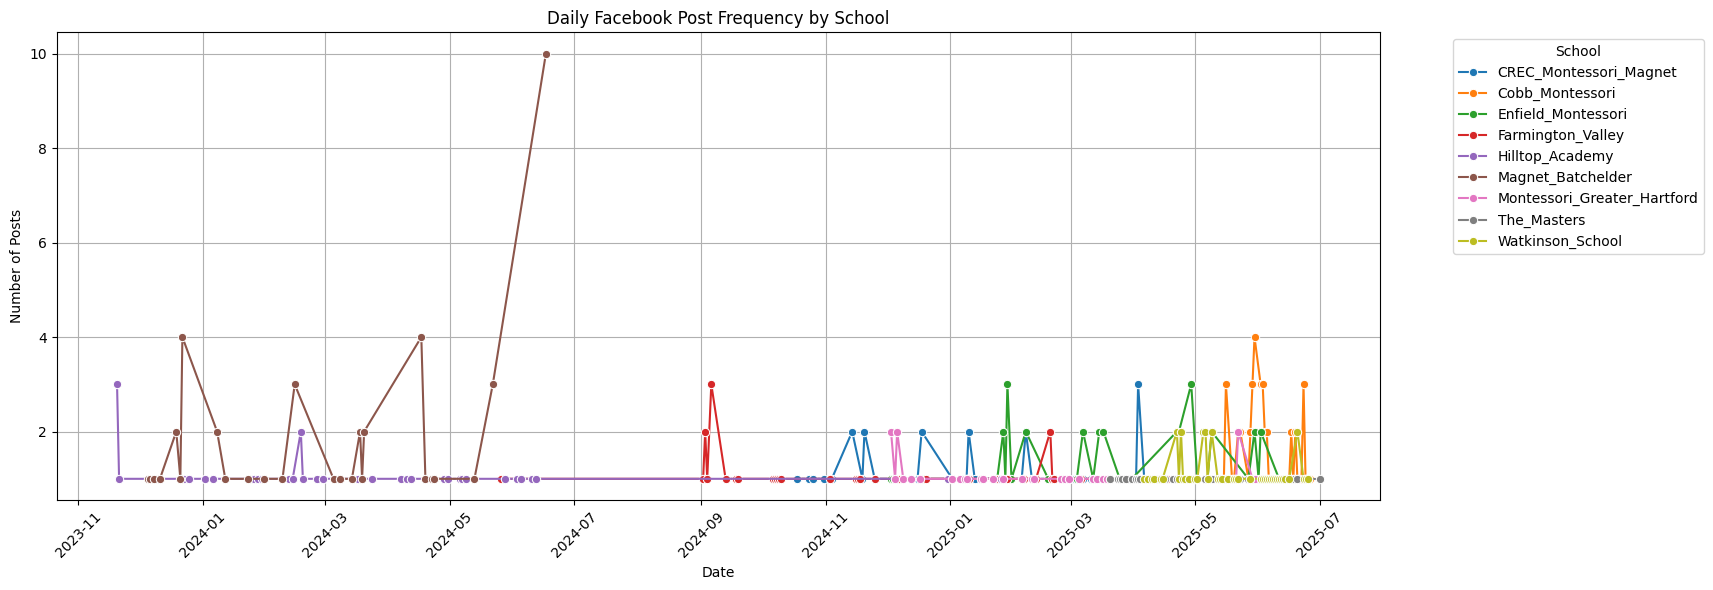

In [23]:
# LET'S START SOME EDA. FREQUENCY OF POSTING FIRST
# Group by school and exact post date
daily_post_counts = (
    merged_df.groupby(['school_name', 'timestamp'])
             .size()
             .reset_index(name='post_count')
)


plt.figure(figsize=(14, 6))
sns.lineplot(
    data=daily_post_counts,
    x='timestamp',
    y='post_count',
    hue='school_name',
    marker='o'
)

plt.title('Daily Facebook Post Frequency by School')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='School', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

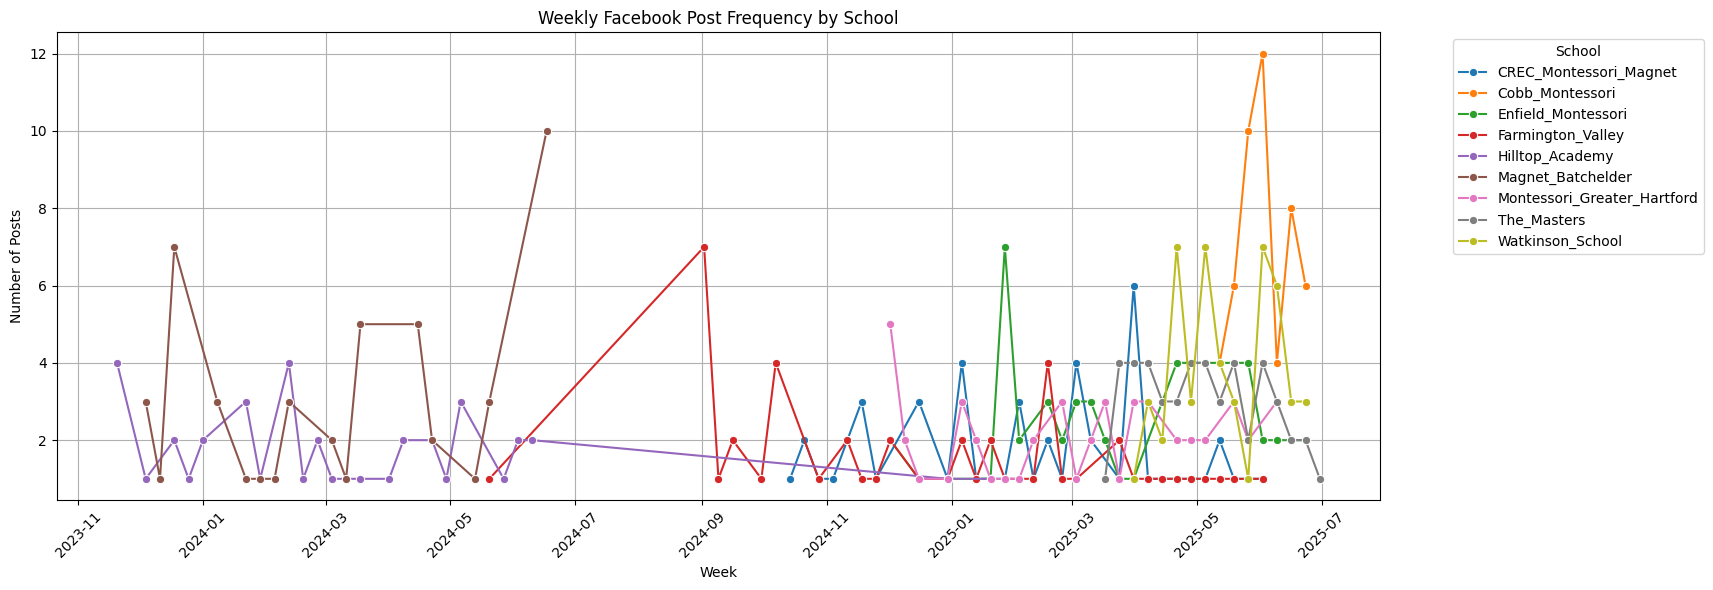

In [24]:
# Create a week-start column
merged_df['week_start'] = merged_df['timestamp'] - pd.to_timedelta(merged_df['timestamp'].dt.weekday, unit='d')

# Group by school and week
weekly_post_counts = (
    merged_df.groupby(['school_name', 'week_start'])
             .size()
             .reset_index(name='post_count')
)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=weekly_post_counts,
    x='week_start',
    y='post_count',
    hue='school_name',
    marker='o'
)

plt.title('Weekly Facebook Post Frequency by School')
plt.xlabel('Week')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='School', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

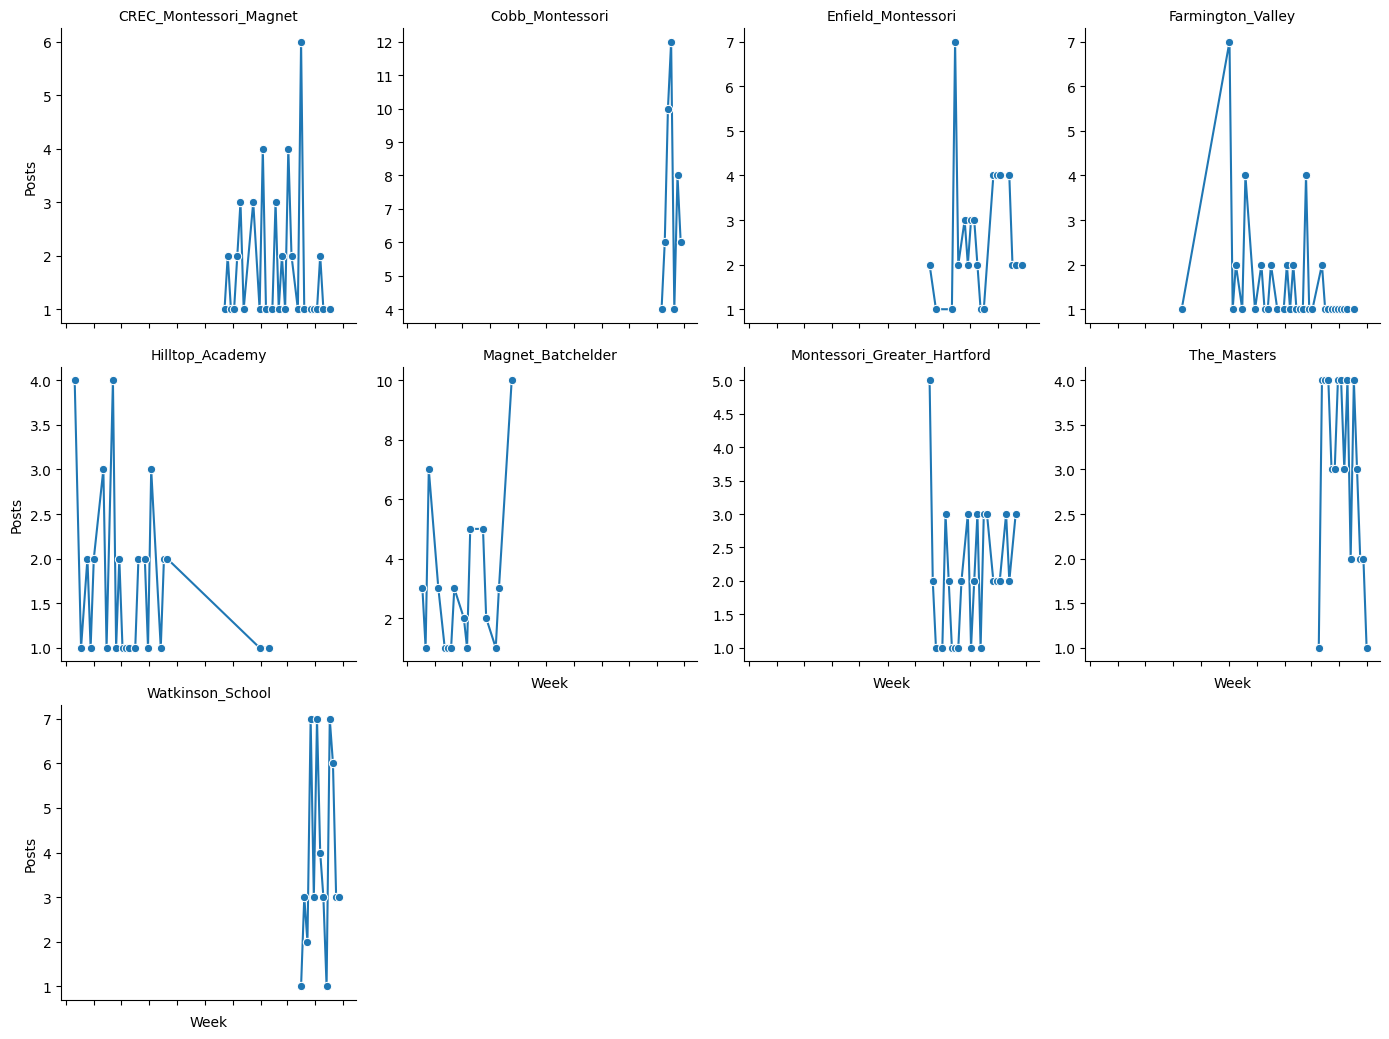

In [25]:
g = sns.FacetGrid(weekly_post_counts, col="school_name", col_wrap=4, height=3.5, sharey=False)
g.map_dataframe(sns.lineplot, x="week_start", y="post_count", marker="o")
g.set_titles("{col_name}")
g.set_axis_labels("Week", "Posts")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

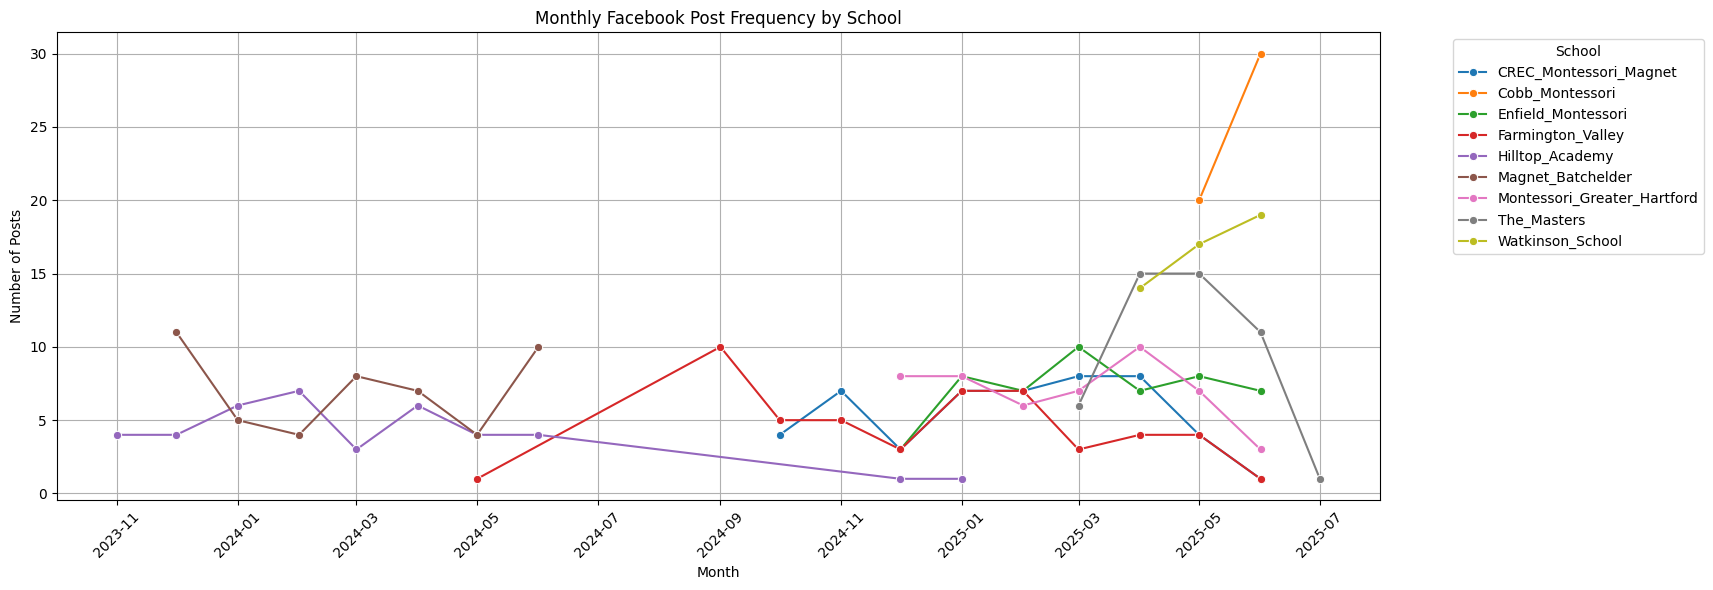

In [26]:
# Create a new column that marks the first day of each month
merged_df['month_start'] = merged_df['timestamp'].values.astype('datetime64[M]')

monthly_post_counts = (
    merged_df.groupby(['school_name', 'month_start'])
             .size()
             .reset_index(name='post_count')
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_post_counts,
    x='month_start',
    y='post_count',
    hue='school_name',
    marker='o'
)

plt.title('Monthly Facebook Post Frequency by School')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='School', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


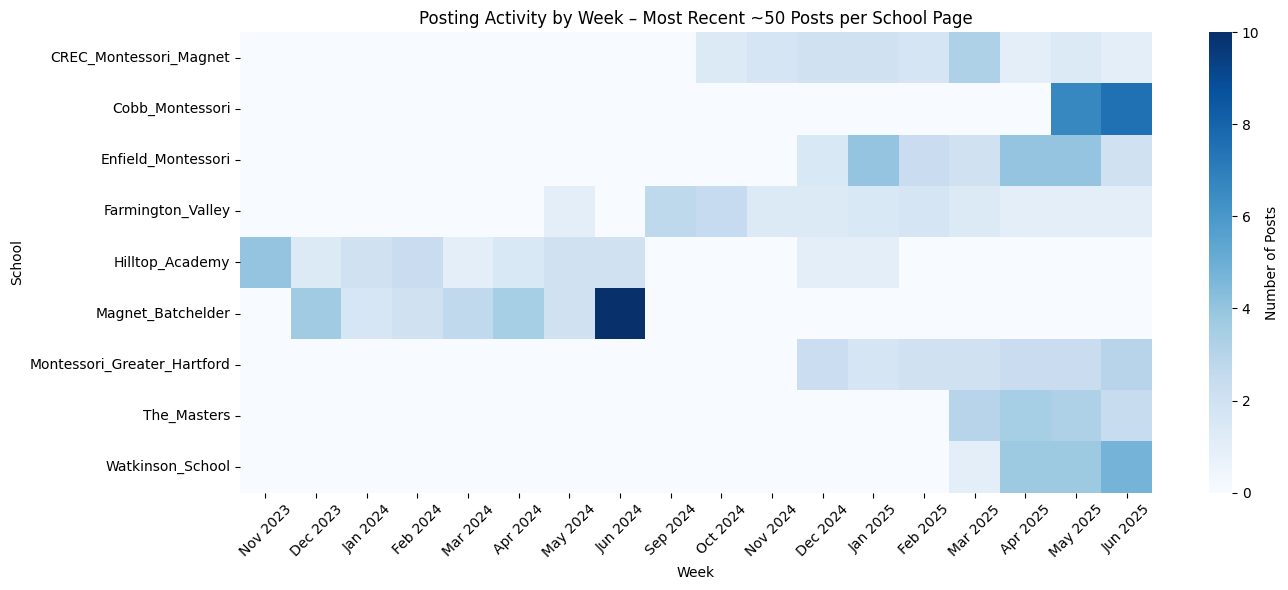

In [27]:
# Step 1: Create a formatted week label (e.g., "Jun 2024")
weekly_post_counts['week_label'] = weekly_post_counts['week_start'].dt.strftime('%b %Y')

# Step 2: Create pivot table using formatted labels
heatmap_data = weekly_post_counts.pivot_table(
    index='school_name',
    columns='week_label',
    values='post_count',
    fill_value=0
)

# Optional: Sort columns chronologically by parsing back to datetime
heatmap_data = heatmap_data.reindex(
    sorted(heatmap_data.columns, key=lambda x: pd.to_datetime(x, format='%b %Y')),
    axis=1
)

# Step 3: Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="Blues", cbar_kws={'label': 'Number of Posts'})
plt.title("Posting Activity by Week – Most Recent ~50 Posts per School Page")
plt.xlabel("Week")
plt.ylabel("School")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a

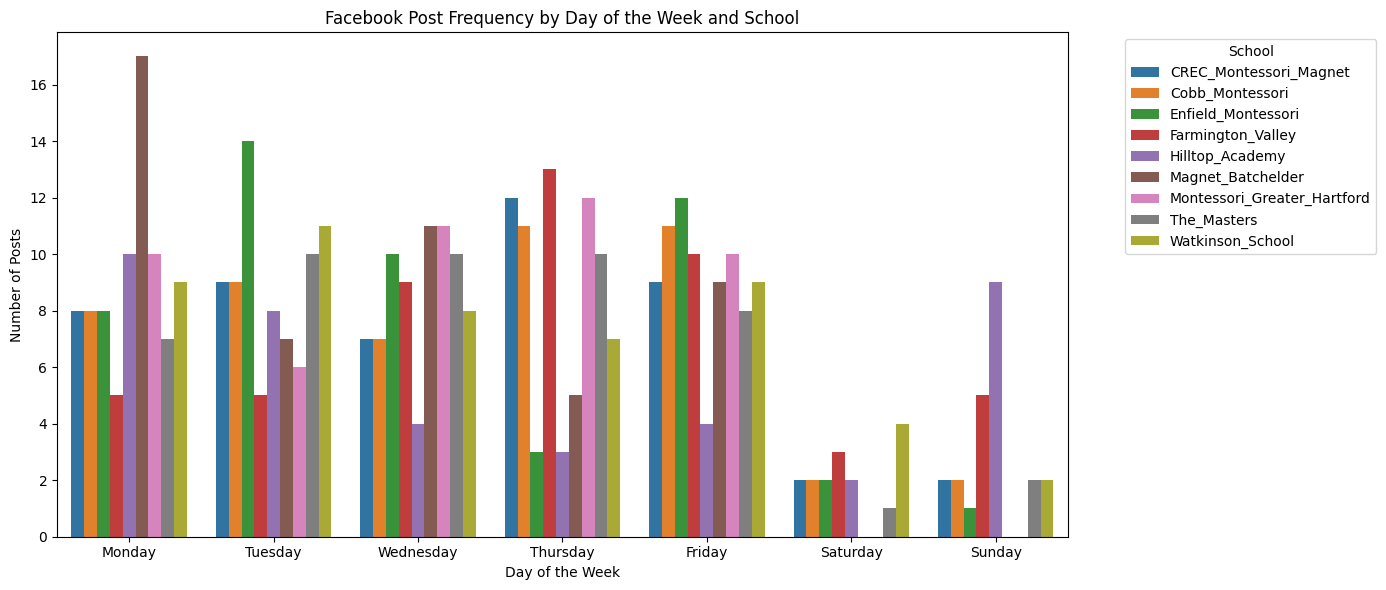

In [28]:
weekday_counts = (
    merged_df.groupby(['school_name', 'weekday'])
             .size()
             .reset_index(name='post_count')
)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts['weekday'] = pd.Categorical(weekday_counts['weekday'], categories=weekday_order, ordered=True)
weekday_counts = weekday_counts.sort_values(['school_name', 'weekday'])


plt.figure(figsize=(14, 6))
sns.barplot(
    data=weekday_counts,
    x='weekday',
    y='post_count',
    hue='school_name'
)

plt.title("Facebook Post Frequency by Day of the Week and School")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Posts")
plt.legend(title='School', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48784/2238693064.py:53: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


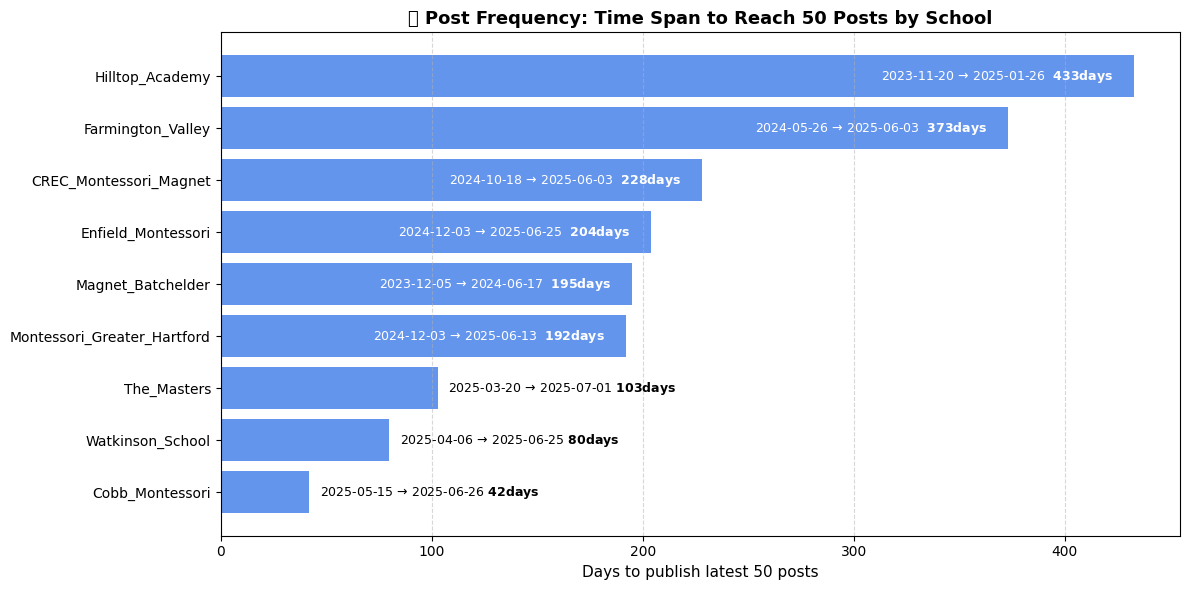

In [29]:
# let's see how long it took to the schools to post 50 times:
# Step 1: Sort by most recent post
df_sorted = merged_df.sort_values(['school_name', 'timestamp'], ascending=[True, False])

# Step 2: Take the latest 50 posts per school
df_50 = df_sorted.groupby('school_name').head(50)

# Step 3: Calculate span and boundaries
span_df = (
    df_50.groupby('school_name')['timestamp']
    .agg(
        days_span=lambda x: (x.max() - x.min()).days,
        most_recent='max',
        oldest='min'
    )
    .reset_index()
)

# Sort for visual clarity
# Sort for plotting
span_df = span_df.sort_values('days_span', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(span_df['school_name'], span_df['days_span'], color='cornflowerblue')

# Add aligned labels
for i, row in span_df.iterrows():
    delta = f"({row['days_span']} days)"
    label = f"{row['oldest'].date()} → {row['most_recent'].date()} "
    
    # Estimate if label fits inside the bar
    if row['days_span'] > 150:
        # Inside bar
        ax.text(
            row['days_span'] - 10, i,
            f"{label} " + r"$\bf{" + f"{row['days_span']} days" + "}$",
            va='center', ha='right', fontsize=9, color='white'
        )
    else:
        # Outside bar
        ax.text(
            row['days_span'] + 5, i,
            f"{label}" + r"$\bf{" + f"{row['days_span']} days" + "}$",
            va='center', ha='left', fontsize=9, color='black'
        )

# Aesthetics
ax.set_xlabel("Days to publish latest 50 posts", fontsize=11)
ax.set_title("📅 Post Frequency: Time Span to Reach 50 Posts by School", fontsize=13, weight='bold')
ax.tick_params(axis='y', labelsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [30]:
merged_df.describe()

,timestamp,comments,reactions,shares,year,month,day,week,week_start,month_start
count,435,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.0,435,435
mean,2025-01-09 05:34:20.689655296,0.781609,13.420690,1.022989,2024.641379,5.131034,15.526437,20.65977,2025-01-06 22:00:49.655172608,2024-12-25 16:56:16
min,2023-11-20 00:00:00,0.000000,0.000000,0.000000,2023.000000,1.000000,1.000000,1.0,2023-11-20 00:00:00,2023-11-01 00:00:00
25%,2024-11-09 00:00:00,0.000000,5.000000,0.000000,2024.000000,3.000000,7.000000,12.0,2024-11-07 12:00:00,2024-11-01 00:00:00
50%,2025-03-24 00:00:00,0.000000,10.000000,0.000000,2025.000000,5.000000,16.000000,19.0,2025-03-24 00:00:00,2025-03-01 00:00:00
75%,2025-05-18 12:00:00,1.000000,19.000000,1.000000,2025.000000,6.000000,23.000000,24.0,2025-05-15 12:00:00,2025-05-01 00:00:00
max,2025-07-01 00:00:00,27.000000,109.000000,49.000000,2025.000000,12.000000,31.000000,52.0,2025-06-30 00:00:00,2025-07-01 00:00:00
std,NaN,1.959411,13.075465,3.489210,0.564003,3.007491,8.686878,12.853629,NaN,NaN


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

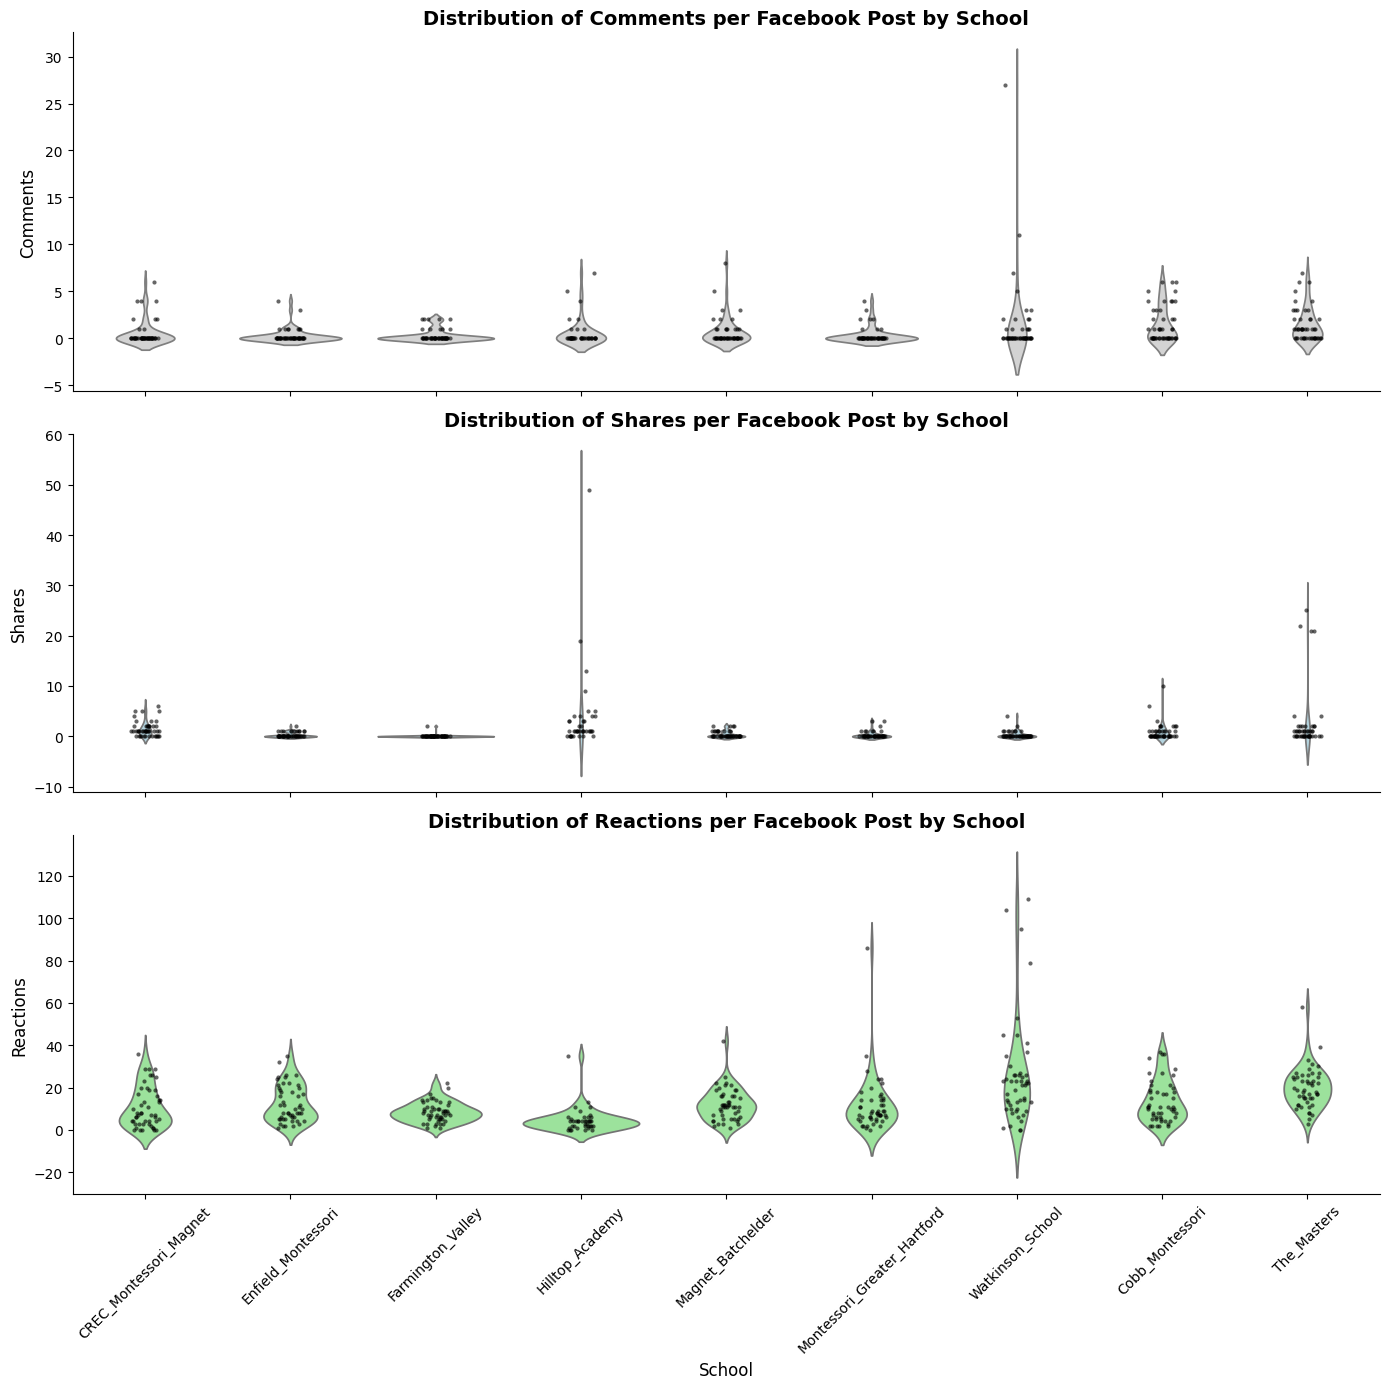

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

metrics = ['comments', 'shares', 'reactions']
colors = ['lightgray', 'lightblue', 'lightgreen']
titles = ['Comments', 'Shares', 'Reactions']

# Sort schools once for consistent order
school_order = (
    merged_df.groupby('school_name')['comments']
    .median()
    .sort_values()
    .index
)

for ax, metric, color, title in zip(axes, metrics, colors, titles):
    sns.violinplot(
        x='school_name',
        y=metric,
        data=merged_df,
        color=color,
        inner=None,
        order=school_order,
        ax=ax
    )
    
    sns.stripplot(
        x='school_name',
        y=metric,
        data=merged_df,
        color='black',
        size=3,
        alpha=0.6,
        jitter=True,
        order=school_order,
        ax=ax
    )
    
    ax.set_title(f'Distribution of {title} per Facebook Post by School', fontsize=14, weight='bold')
    ax.set_ylabel(f'{title}', fontsize=12)
    ax.set_xlabel('')

# Final x-axis label and formatting
axes[-1].set_xlabel('School', fontsize=12)
axes[-1].tick_params(axis='x', rotation=45)
sns.despine()
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

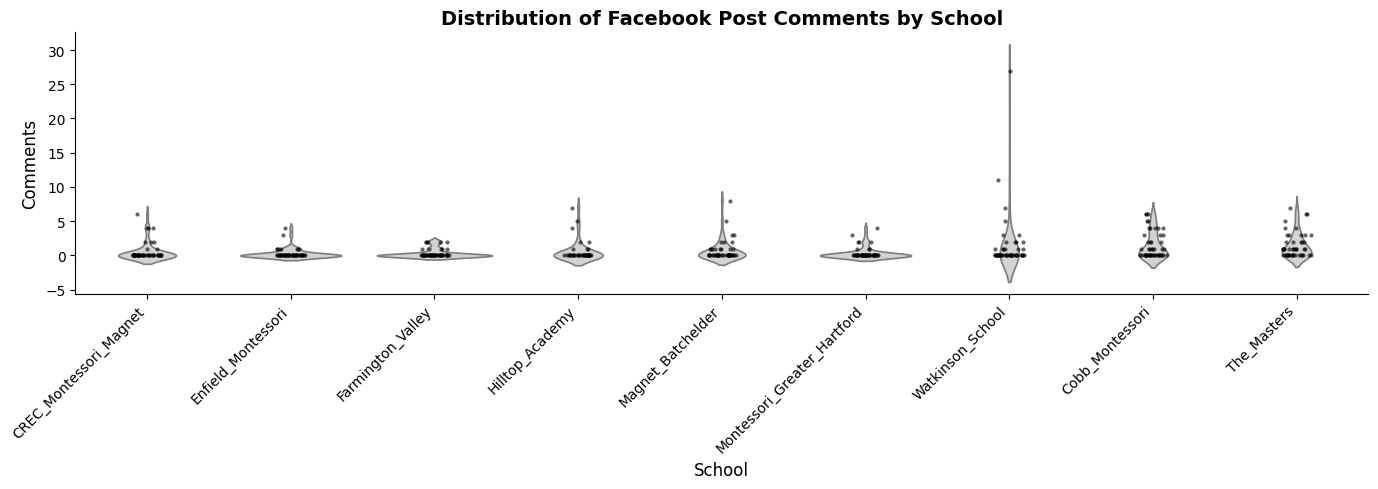

In [32]:
plt.figure(figsize=(14, 5))

# Sort schools by median comment count
school_order = (
    merged_df.groupby('school_name')['comments']
    .median()
    .sort_values()
    .index
)

sns.violinplot(
    data=merged_df,
    x='school_name',
    y='comments',
    order=school_order,
    color='lightgray',
    inner=None
)

sns.stripplot(
    data=merged_df,
    x='school_name',
    y='comments',
    order=school_order,
    color='black',
    size=3,
    alpha=0.6,
    jitter=True
)

plt.title("Distribution of Facebook Post Comments by School", fontsize=14, weight='bold')
plt.xlabel("School", fontsize=12)
plt.ylabel("Comments", fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

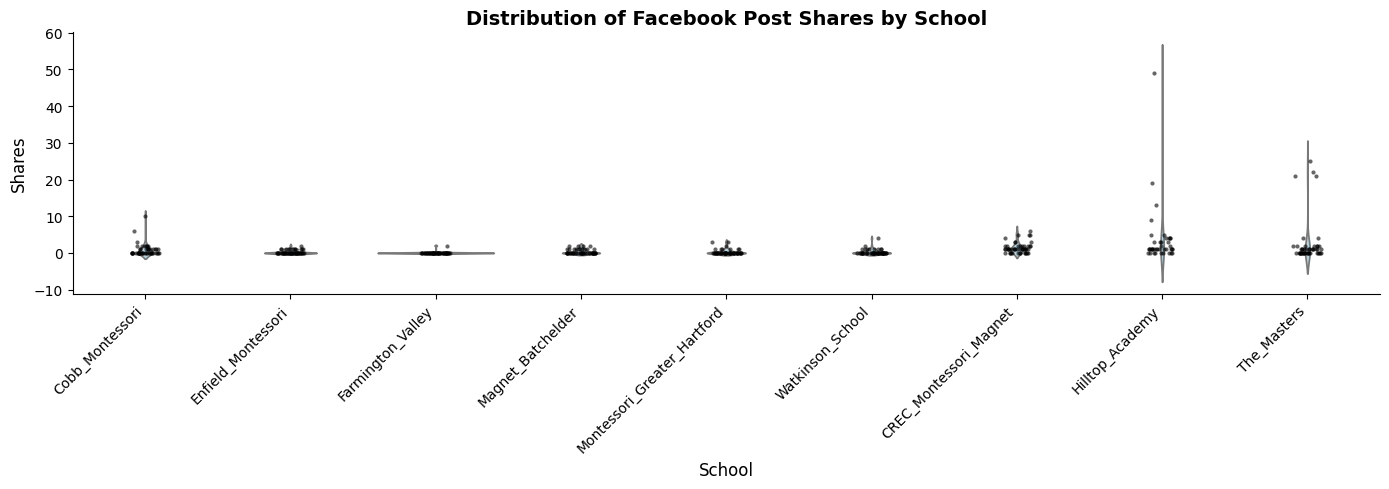

In [33]:
plt.figure(figsize=(14, 5))

# Sort schools by median comment count
school_order = (
    merged_df.groupby('school_name')['shares']
    .median()
    .sort_values()
    .index
)

sns.violinplot(
    data=merged_df,
    x='school_name',
    y='shares',
    order=school_order,
    color='lightblue',
    inner=None
)

sns.stripplot(
    data=merged_df,
    x='school_name',
    y='shares',
    order=school_order,
    color='black',
    size=3,
    alpha=0.6,
    jitter=True
)

plt.title("Distribution of Facebook Post Shares by School", fontsize=14, weight='bold')
plt.xlabel("School", fontsize=12)
plt.ylabel("Shares", fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

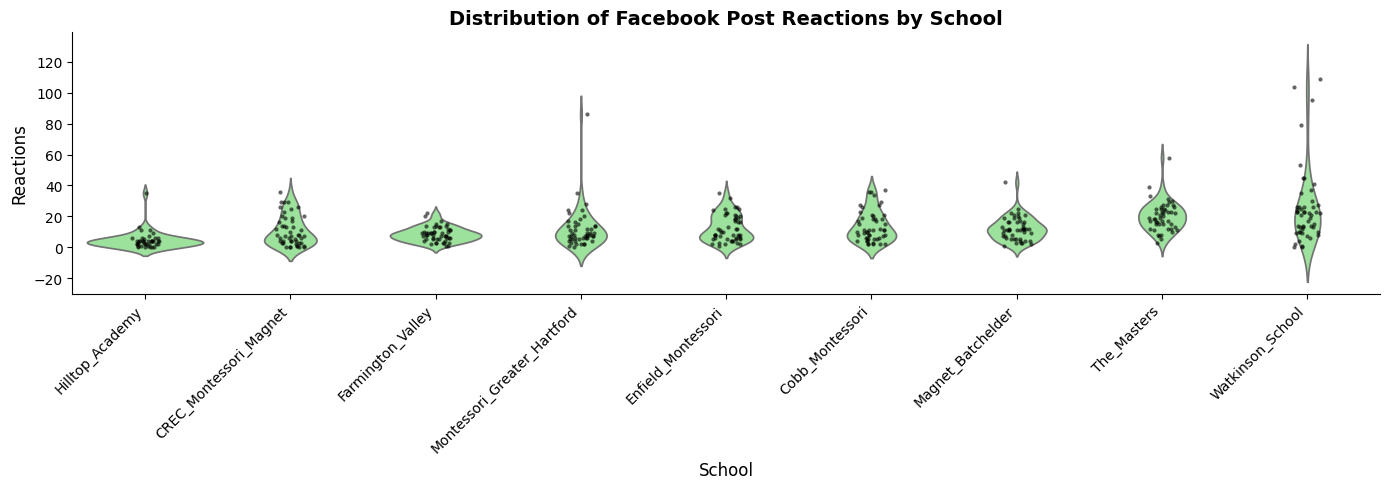

In [34]:
plt.figure(figsize=(14, 5))

# Sort schools by median comment count
school_order = (
    merged_df.groupby('school_name')['reactions']
    .median()
    .sort_values()
    .index
)

sns.violinplot(
    data=merged_df,
    x='school_name',
    y='reactions',
    order=school_order,
    color='lightgreen',
    inner=None
)

sns.stripplot(
    data=merged_df,
    x='school_name',
    y='reactions',
    order=school_order,
    color='black',
    size=3,
    alpha=0.6,
    jitter=True
)

plt.title("Distribution of Facebook Post Reactions by School", fontsize=14, weight='bold')
plt.xlabel("School", fontsize=12)
plt.ylabel("Reactions", fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

In [35]:
merged_df.to_csv('facebook_posts_cleaned.csv', index=False)